# Integrated Urban Data Pipeline: Linking Traffic, Weather, and Air Quality in Chicago

## Project Overview

Building a repeatable, end-to-end data pipeline that links the City of Chicago's traffic, weather, and air quality datasets is the main goal of our project. Instead of creating a predictive model, the goal is to show how extensive urban data can be ethically gathered, processed, and combined to aid in environmental analysis. This is in line with the course's focus on workflow automation, quality assessment, metadata, and data lifecycle management.

The main objectives are:

- To create a single, cohesive dataset by combining information from several reliable, independent sources.
- Automating data transformation, integration, and cleaning procedures will enable dependable reruns.
- To assess the relationship between variations in citywide air quality and weather and traffic patterns.
- Through workflow automation and clear GitHub documentation, we aim to demonstrate ethical data handling, transparent processing steps, and full reproducibility.

### *Rishabh add: Data sources + acquisition details + ethical data handling and how you got the data ethically*

## Initial Storage Strategy

The Air quality and Weather datasets size is very managable. However, because the traffic dataset contains 78+ million rows, a careful storage plan is required. We are adopting a hybrid approach using:
- Chunked Parquet Storage (for large data)
- Direct CSV Storage (for smaller datasets)
- Metadata + Naming Conventions

For naming conventions we will focus on that later on for the final submission. Currently we want to just orginize everything together. For example a short metadata file (.json) describing units, schema, and source. Also adding strict lowercase, snake_case naming

In [17]:
import pandas as pd

This is just air and weather data. For Air Quality I only pulled the ones that were 2024 in chicago as that is all I want to focus on

*Data lifecycle collect data*

In [18]:
dfAir = pd.read_csv("../data/raw/Air.csv")
AirChicago = dfAir[dfAir['City'] == 'Chicago']
AirChicago["Date"] = pd.to_datetime(AirChicago["Date"], errors="coerce")
AirChicago = AirChicago[AirChicago["Date"].dt.year == 2024]
dfWeather = pd.read_csv("../data/raw//Weather.csv")
dfWeather = dfWeather[dfWeather["YEAR"]== 2024]

/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_78741/2561640002.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AirChicago["Date"] = pd.to_datetime(AirChicago["Date"], errors="coerce")


This is the traffic dataset. It's so large it needs to be split into multiple chunks. It was split into a total of 78 datasets. **Additionally because of its size 20+ gb we were unable to upload it to git. We had confirmed with the professor if this was fine and he said it was.**

In [ ]:
import pandas as pd

reader = pd.read_csv(
    "traffic.csv",
    engine="c",
    dtype=str,
    chunksize=1_000_000,
    on_bad_lines="skip"
)

for i, chunk in enumerate(reader):
    chunk.to_parquet(f"traffic{i:03}.parquet", index=False)

In [21]:
import os

parquets = [f for f in os.listdir() if f.endswith(".parquet")]
print(len(parquets), "parquet files found")
print(parquets[:10])


78 parquet files found
['big2_part_033.parquet', 'big2_part_023.parquet', 'big2_part_051.parquet', 'big2_part_041.parquet', 'big2_part_048.parquet', 'big2_part_058.parquet', 'big2_part_077.parquet', 'big2_part_067.parquet', 'big2_part_015.parquet', 'big2_part_005.parquet']


In [22]:
dfBig = pd.read_parquet("traffic.parquet")

I just combined everything into one dataset. What I did was I just took the traffic for a specfic day (there were multiple per day) and did the middle observation (floored if it was an even number)

*Data managment* (storing data properly)

In [8]:
from glob import glob

parts = sorted(glob("traffic*.parquet"))
out = []

for p in parts:
    x = pd.read_parquet(p)
    x["TIME"] = pd.to_datetime(
        x["TIME"],
        format="%m/%d/%Y %I:%M:%S %p",
        errors="coerce"
    )
    x = x.dropna(subset=["TIME"])
    x["DATE"] = x["TIME"].dt.date
    x = x.sort_values(["STREET", "DATE", "TIME"])
    
    g = x.groupby(["STREET", "DATE"])
    n = g["TIME"].transform("size")
    pos = g.cumcount()
    k = n // 2
    
    out.append(x[pos.eq(k)])

one_per_street_day = pd.concat(out, ignore_index=True).drop(columns=["DATE"])


looking at these there seems to be a mix ranging from early morning, noon, and night

Now comes the merging of the data:

In [24]:
traffic = one_per_street_day.copy()
traffic["TIME"] = pd.to_datetime(traffic["TIME"], errors="coerce")
traffic = traffic.dropna(subset=["TIME"])
traffic["DATE"] = traffic["TIME"].dt.date
traffic["HOUR"] = traffic["TIME"].dt.hour

In [25]:
weather = dfWeather.copy()
weather = weather.rename(columns={"MO": "MONTH", "DY": "DAY", "HR": "HOUR"})
weather["DATE"] = pd.to_datetime(
    dict(year=weather["YEAR"], month=weather["MONTH"], day=weather["DAY"])
).dt.date
weather = weather.drop(columns=["REF", "YEAR", "MONTH", "DAY"], errors="ignore")
weather = weather.sort_values(["DATE", "HOUR"]).drop_duplicates(["DATE", "HOUR"], keep="first")

In [26]:
air = AirChicago.copy()
air["Date"] = pd.to_datetime(air["Date"], errors="coerce").dt.date
air = air.dropna(subset=["Date"])
air = air.rename(columns={"Date": "DATE"})
air = air.drop(columns=["City"], errors="ignore")

In [27]:
traffic_weather = pd.merge(traffic, weather, on=["DATE", "HOUR"], how="left")
final_df = pd.merge(traffic_weather, air, on="DATE", how="left")
final_df = final_df[['TIME', 'SEGMENT_ID', 'SPEED', 'STREET', 'DIRECTION', 'FROM_STREET',
       'TO_STREET', 'LENGTH', 'STREET_HEADING', 'COMMENTS', 'BUS_COUNT',
       'MESSAGE_COUNT', 'RECORD_ID', 'START_LATITUDE', 'START_LONGITUDE', 
       'END_LATITUDE', 'END_LONGITUDE', 'START_LOCATION', 'END_LOCATION', 
       'TEMP', 'PRCP', 'HMDT', 'WND_SPD', 'ATM_PRESS', 'Pm2.5', 
       'Pm10', 'No2', 'So2', 'Co', 'Aqi']]

Now this gets me the traffic dataset that has been processed so that we don't have to worry about a 20+ gb dataset that cannot be uploaded.

In [1]:
#final_df.to_csv("final_dataset.csv", index=False)

In [31]:
final_df_cleaned = pd.read_csv("../data/cleaned/final_dataset_cleaned.csv")

### original dataset is 20GB and could not be uploaded to git so I downloaded the filtered dataframe

### Data Lifecycle Alignment
Our project follows the full data lifecycle described in the course. After collecting raw traffic, weather, and air quality data, we entered the Data Processing and Preparation phase. This is the intermediary step between data collection and data analysis, and it is responsible for transforming heterogeneous, messy datasets into a structured form that is ready for analytics.

In this phase, we performed:

- datatype standardization (converting object fields to numeric or string)
- timestamp parsing and normalization of DATE and HOUR
- removal of invalid or impossible values (e.g., negative AQI, unrealistic speeds)
- geospatial sanity checks on latitude and longitude
- string normalization (uppercase formatting, trimming whitespace)
- deduplication of segment-time records
- integration across the three datasets using consistent time-based keys

This processing layer is essential in the data lifecycle because analytics cannot begin until the data is clean, consistent, and integrated. Only after completing this stage can we move into descriptive analysis and exploratory work.

## Data analysis

### Traffic Speed vs Weather

In [36]:
weather_cols = ["TEMP", "PRCP", "WND_SPD"]
corr_speed_weather = final_df_cleaned[["SPEED"] + weather_cols].corr()
corr_speed_weather

temp_bins = pd.cut(final_df_cleaned["TEMP"], bins=[-50, 0, 10, 20, 30, 50], right=False)
speed_by_temp = final_df_cleaned.groupby(temp_bins)["SPEED"].mean()

prcp_bins = pd.cut(final_df_cleaned["PRCP"], bins=[-0.0001, 0, 1, 5, 50], right=False)
speed_by_prcp = final_df_cleaned.groupby(prcp_bins)["SPEED"].mean()

wnd_bins = pd.cut(final_df_cleaned["WND_SPD"], bins=[-0.1, 1, 5, 10, 50], right=False)
speed_by_wind =final_df_cleaned.groupby(wnd_bins)["SPEED"].mean()

corr_speed_weather, speed_by_temp, speed_by_prcp, speed_by_wind


/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_519/334452580.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_by_temp = final_df_cleaned.groupby(temp_bins)["SPEED"].mean()
/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_519/334452580.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_by_prcp = final_df_cleaned.groupby(prcp_bins)["SPEED"].mean()
/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_519/334452580.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cu

(            SPEED      TEMP      PRCP   WND_SPD
 SPEED    1.000000 -0.010088 -0.025509 -0.003154
 TEMP    -0.010088  1.000000 -0.246322 -0.426764
 PRCP    -0.025509 -0.246322  1.000000  0.239805
 WND_SPD -0.003154 -0.426764  0.239805  1.000000,
 TEMP
 [-50, 0)          NaN
 [0, 10)     25.146259
 [10, 20)    25.032238
 [20, 30)    24.982372
 [30, 50)          NaN
 Name: SPEED, dtype: float64,
 PRCP
 [-0.0001, 0.0)          NaN
 [0.0, 1.0)        25.080623
 [1.0, 5.0)        24.282759
 [5.0, 50.0)       23.980036
 Name: SPEED, dtype: float64,
 WND_SPD
 [-0.1, 1.0)     24.971326
 [1.0, 5.0)      25.039366
 [5.0, 10.0)     25.054081
 [10.0, 50.0)    24.668197
 Name: SPEED, dtype: float64)

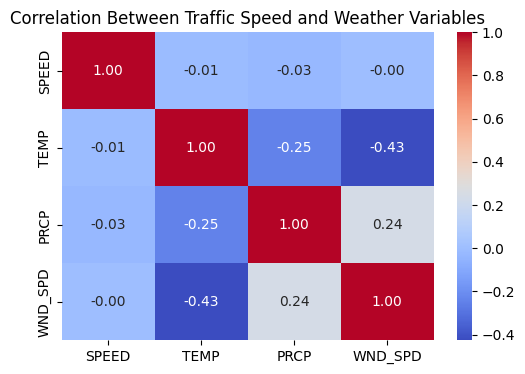

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

weather_cols = ["SPEED", "TEMP", "PRCP", "WND_SPD"]
plt.figure(figsize=(6,4))
sns.heatmap(final_df_cleaned[weather_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Traffic Speed and Weather Variables")
plt.show()


/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_519/89657944.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speed_by_prcp = final_df_cleaned.groupby(prcp_bins)["SPEED"].mean()


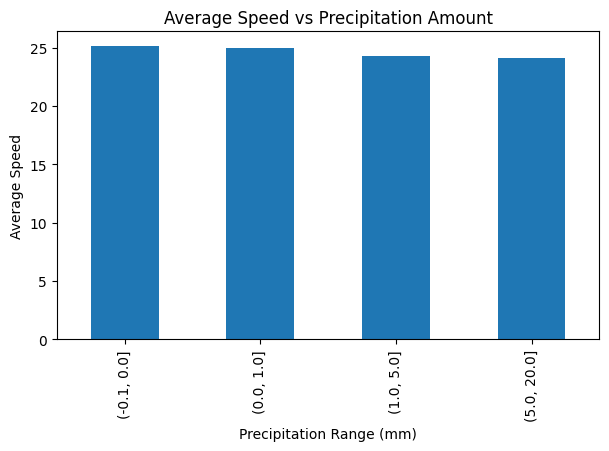

In [43]:
prcp_bins = pd.cut(final_df_cleaned["PRCP"], bins=[-0.1, 0, 1, 5, 20])
speed_by_prcp = final_df_cleaned.groupby(prcp_bins)["SPEED"].mean()

speed_by_prcp.plot(kind="bar", figsize=(7,4))
plt.title("Average Speed vs Precipitation Amount")
plt.xlabel("Precipitation Range (mm)")
plt.ylabel("Average Speed")
plt.show()


**Takeaways**

When looking at how weather affects traffic speed, the results are honestly pretty surprising because nothing really changes that much and the correlation numbers are basically near zero, so even when we break speeds down by temperature ranges or different levels of precipitation or wind, the average speed stays almost the same. Even on colder days or when it is raining a bit, traffic only slows by maybe a mile per hour, which is barely noticeable. Overall, the data makes it seem like Chicago traffic basically keeps moving the same regardless of normal weather variations, which is not what you would normally expect but that is what the numbers show.

### Air Quality vs Traffic Congestion

In [46]:
aq_cols = ["Pm2.5", "Pm10", "No2", "So2", "Co", "Aqi"]
traffic_cols = ["BUS_COUNT", "MESSAGE_COUNT"]

corr_traffic_aq = final_df_cleaned[traffic_cols + aq_cols].corr()
corr_traffic_aq.loc[traffic_cols, aq_cols]

final_df_cleaned["congestion_index"] = final_df_cleaned["LENGTH"] / final_df_cleaned["SPEED"]

corr_congestion_aq = final_df_cleaned[["congestion_index"] + aq_cols].corr()
corr_congestion_aq.loc[["congestion_index"], aq_cols]

hourly_agg = (
    final_df_cleaned.groupby("HOUR")[traffic_cols + aq_cols]
    .mean()
    .sort_index()
)
hourly_agg.head()


,BUS_COUNT,MESSAGE_COUNT,Pm2.5,Pm10,No2,So2,Co,Aqi
HOUR,,,,,,,,
0,0.357143,2.357143,112.571429,149.698571,47.332857,26.671429,3.933571,251.785714
1,0.000000,0.000000,156.880000,175.448333,41.228333,20.003333,4.793333,279.666667
2,0.000000,0.000000,114.660833,194.671250,52.836250,28.488750,5.741250,291.333333
3,0.000000,0.000000,114.425278,182.374444,46.177778,25.776111,4.873056,208.444444
4,0.000000,0.000000,101.178095,160.032381,56.861429,21.988095,5.123810,229.857143


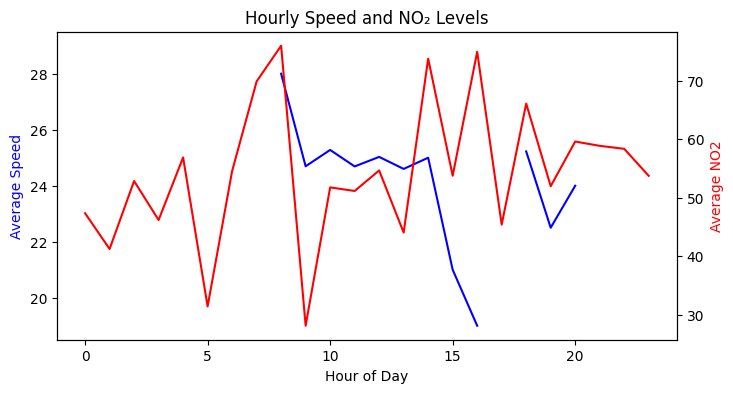

In [48]:
hourly = final_df_cleaned.groupby("HOUR")[["SPEED", "No2"]].mean()

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.plot(hourly.index, hourly["SPEED"], label="Speed", color="blue")
ax2.plot(hourly.index, hourly["No2"], label="NO2", color="red")

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Average Speed", color="blue")
ax2.set_ylabel("Average NO2", color="red")
plt.title("Hourly Speed and NO₂ Levels")
plt.show()


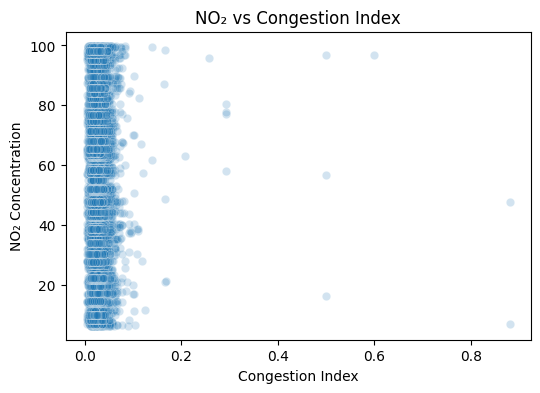

In [50]:
final_df_cleaned["congestion_index"] = final_df_cleaned["LENGTH"] / final_df_cleaned["SPEED"]

plt.figure(figsize=(6,4))
sns.scatterplot(data=final_df_cleaned, x="congestion_index", y="No2", alpha=0.2)
plt.title("NO₂ vs Congestion Index")
plt.xlabel("Congestion Index")
plt.ylabel("NO₂ Concentration")
plt.show()


**Takeaways**

For traffic and air quality, the patterns are a bit more interesting because NO2 does go up during rush hour and speeds drop a little, but when you actually look at the scatterplot of congestion versus NO2 it becomes clear that the congestion index barely changes at all and almost all the values sit under 0.1, so the NO2 levels are high even when congestion is technically low. The hourly plot shows that NO2 follows the daily rhythm of people commuting, but still the relationship is not tight enough to say traffic on one specific road segment is causing the pollution spike. It is more like the whole city moves together and that affects NO2, not just the local area where the speed was measured.

### Weather and Air Quality Interaction

In [38]:
corr_prcp_aq = final_df_cleaned[["PRCP"] + aq_cols].corr()
corr_prcp_aq.loc[["PRCP"], aq_cols]

corr_wind_aq = final_df_cleaned[["WND_SPD"] + aq_cols].corr()
corr_wind_aq.loc[["WND_SPD"], aq_cols]

final_df_cleaned["is_rainy"] = final_df_cleaned["PRCP"] > 0
rain_vs_aq = final_df_cleaned.groupby("is_rainy")[aq_cols].mean()

wind_bins = pd.cut(final_df_cleaned["WND_SPD"], bins=[-0.1, 1, 5, 10, 50], labels=["calm", "breeze", "windy", "very_windy"])
wind_vs_aq = final_df_cleaned.groupby(wind_bins)[aq_cols].mean()

corr_prcp_aq.loc[["PRCP"], aq_cols], corr_wind_aq.loc[["WND_SPD"], aq_cols], rain_vs_aq, wind_vs_aq


/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_519/3935841880.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_vs_aq = final_df_cleaned.groupby(wind_bins)[aq_cols].mean()


(         Pm2.5      Pm10       No2       So2        Co       Aqi
 PRCP -0.013596  0.015268 -0.022716 -0.131272  0.064159 -0.058114,
             Pm2.5      Pm10       No2       So2        Co       Aqi
 WND_SPD -0.058869  0.031733  0.042754 -0.064155 -0.155496 -0.104809,
                Pm2.5        Pm10        No2        So2        Co         Aqi
 is_rainy                                                                    
 False     107.913746  159.601545  52.705277  27.210374  4.656858  257.949015
 True      106.396872  159.802320  57.224673  23.196764  5.079841  227.365877,
                  Pm2.5        Pm10        No2        So2        Co         Aqi
 WND_SPD                                                                       
 calm        129.083297  113.866034  50.624914  35.077780  7.430797  333.286638
 breeze      108.808810  157.304439  52.052110  25.769191  5.020122  253.031485
 windy       104.659234  163.977375  57.312298  25.448390  4.594516  246.782673
 very_windy  10

/var/folders/5_/638vlyvx5v57tb9j18y8bw_h0000gn/T/ipykernel_519/3512926546.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_vs_aq = final_df_cleaned.groupby(wind_bins)[["Pm2.5", "Pm10", "No2"]].mean()


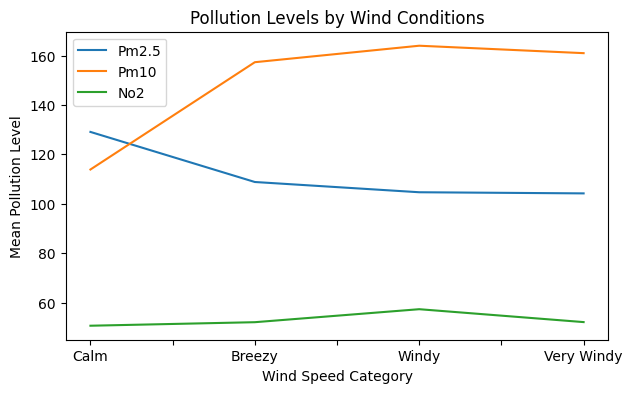

In [52]:
wind_bins = pd.cut(final_df_cleaned["WND_SPD"], bins=[-0.1, 1, 5, 10, 50],
                   labels=["Calm", "Breezy", "Windy", "Very Windy"])
wind_vs_aq = final_df_cleaned.groupby(wind_bins)[["Pm2.5", "Pm10", "No2"]].mean()

wind_vs_aq.plot(figsize=(7,4))
plt.title("Pollution Levels by Wind Conditions")
plt.xlabel("Wind Speed Category")
plt.ylabel("Mean Pollution Level")
plt.show()


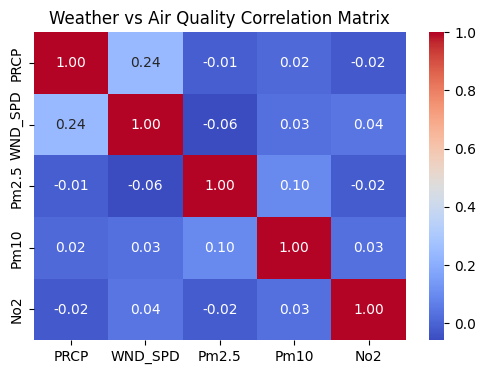

In [53]:
plt.figure(figsize=(6,4))
sns.heatmap(final_df_cleaned[["PRCP", "WND_SPD", "Pm2.5", "Pm10", "No2"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Weather vs Air Quality Correlation Matrix")
plt.show()


**Takeaways**

Wind is really the only weather factor that shows a clear relationship with air quality since PM2.5 keeps going down as wind gets stronger, which makes sense because wind spreads everything out and cleans the air a bit. PM10 actually rises when it is breezy or windy because bigger particles get kicked up into the air and then it drops a little again when wind becomes really strong. Rain does basically nothing in this dataset based on the correlations, so it is not washing out pollution in any obvious way. Overall, weather matters a little for pollution but mostly because wind is able to move the pollutants around, not because storms or temperature changes are doing anything dramatic.